# Introduction to the metrics

To assess the goodnes of the metrics we will take 20 random "prototypical" images from MNIST. 
Then, for each test image, we will compute the distance to all prototypical images and thake the best metric of the two prototypical images and as prediction the label of the best metric among the ten best metrics, just computed.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
from scipy.ndimage import sobel

In [4]:
from torchvision.datasets import MNIST
MNIST_DATASET = MNIST(root='data', train=True, download=True)

In [5]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import time

In [6]:
import matplotlib.patches as mpatches

Label: 0, Index: (28, 28)


(-0.5, 27.5, 27.5, -0.5)

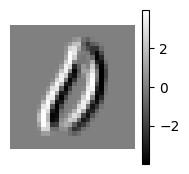

In [7]:
# choose a random image
idx = np.random.randint(0, len(MNIST_DATASET))
# as numPy array
image, label = MNIST_DATASET[idx]
# convert to float
image = (np.array(image, dtype=np.float32)/255)
print(f"Label: {label}, Index: {image.shape}")
# apply a sobel filter

image = sobel(image)
plt.figure(figsize=(2,2))
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.axis('off')

In [8]:
X_train, y_train = MNIST_DATASET.data, MNIST_DATASET.targets
# use sklearn to split the dataset

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.7)
# convert to float
X_train = (np.array(X_train, dtype=np.float32)/255)
X_test = (np.array(X_test, dtype=np.float32)/255)
# apply a sobel filter to each image
X_train = np.array([sobel(image) for image in X_train])
X_test = np.array([ sobel(image) for image in X_test])[:,:,:]
y_test = y_test[:]

# Showcasig the comparison functions

This implementation demonstrates a _KNN-like_ classifier designed to work with images.
The classifier allows us to compare different preprocessing techniques and distance metrics for saliency map analysis.
## How it works
The ``` KNNImages``` class implements a prototype-based classification approach:

1 - **Initialization:** For each class, we store multiple prototypical saliency map examples
2 - **Preprocessing:** Options for clipping and normalization to standardize saliency representations
3 - **Distance Calculation:** For a query sample, we compute distances to all prototypes using the provided metric function
4 - **Classification:** We assign the class with the minimum distance

### Datset Preparation
The MNIST dataset has been normalized to the range [-1, 1] to simulate feature attribution values that would be produced by explanation methods like SHAP or LIME. This normalization allows the saliency maps to represent both positive and negative contributions to model predictions, as is common in feature-importance based explanations in AI approaches.

### Distance Metrics
We've use the distance functions explained earlier

### Results
The  evaluates different preprocessing combinations:

- With/without clipping
- With/without normalization

For each configuration, we report:
- F1 score on the test dataset
- Computation time

This approach provides insights into how different preprocessing steps and distance metrics affect the comparison of saliency maps, which is crucial for developing reliable XAI evaluation methods.



### The prototypical images

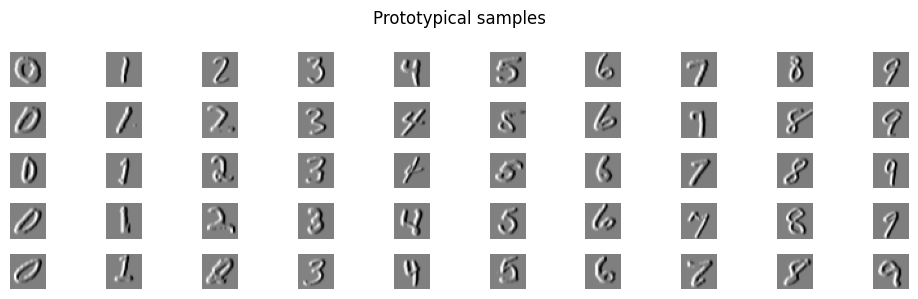

In [9]:
# take k samples from each class
# and store them in a numpy array
k = 5
prototypical_samples = np.zeros((10, k, 28, 28))
for i in range(10):
    found = 0
    while found < k:
        for idx in np.random.permutation(len(X_train)):
            image, label = X_train[idx], y_train[idx]
            #image = (np.array(image, dtype=np.float32)/255)
            #image = sobel(image)
            if label == i:
                prototypical_samples[i][found] = image
                found += 1
                break
    
# draw the samples
plt.figure(figsize=(10, 3))
for j in range(k):
    for i in range(10):
        # plot the images of the same class in the same column
        plt.subplot(k, 10, j*10+i+ 1)
        plt.imshow(prototypical_samples[i][j], cmap='gray')
        plt.axis('off')
plt.suptitle("Prototypical samples")
plt.tight_layout()

In [10]:
#imagine the prototypical as a 2D array
#this is a 2D array of 10x10
prototypical_samples.shape    

(10, 5, 28, 28)

### Hyperparameters 
- Metric - One of the metric listed above
- Clipping - makes the saliency maps in [-1,1]
- Normalization - normalize the mask to the range [-1,1]

In [11]:
def clip_mask(mask):
    """
    Clip the mask to the range [-1, 1]
    """
    return np.clip(mask, -1, 1)
def normalize_mask(mask):
    """
    Normalize the mask to the range [-1, 1]
    """
    mask = mask - np.min(mask)
    mask = mask / np.max(mask)
    mask = 2 * mask - 1
    return mask
sobel


<function scipy.ndimage._filters.sobel(input, axis=-1, output=None, mode='reflect', cval=0.0)>

In [65]:
from scipy.stats import wasserstein_distance
from skimage import metrics
def euclidean_distance(a, b):
    """
    Compute the Euclidean distance between two images.
    """
    return np.sqrt(np.sum((a - b) ** 2))
def cosine_distance(a, b):
    """
    Compute the cosine distance between two vectors
    """
    a = a.flatten()
    b = b.flatten()
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
def emd(a, b):
    return wasserstein_distance(a.flatten(), b.flatten())
def mean_absolute_error(a, b):
    """
    Compute the mean absolute error between two images.
    """
    return np.mean(np.abs(a - b))
# Sign Agreement Ratio (SAR)
def sign_agreement_ratio(a, b):
    """
    Compute the sign agreement ratio between two images.
    """
    a = a.flatten()
    b = b.flatten()
    return 1 - np.mean(np.sign(a) == np.sign(b))
def sign_distance(a, b):
    """
    Compute the sign distance between two images.
    """
    a = a.flatten()
    b = b.flatten()
    return np.mean(np.sign(a) != np.sign(b))
def intersection_over_union(a, b):
    """
    Compute the intersection over union between two images.
    """
    a = a.flatten()
    b = b.flatten()
    intersection = np.sum(np.minimum(a, b))
    union = np.sum(np.maximum(a, b))
    return 1 - intersection / union
def correlation_distance(a, b):
    """
    Compute the correlation distance between two images.
    """
    a = a.flatten()
    b = b.flatten()
    return 1 - np.corrcoef(a, b)[0, 1]
def mean_squared_error(a, b):
    """
    Compute the mean squared error between two images.
    """
    return np.mean((a - b) ** 2)
def ssim(a, b):
    """
    Compute the structural similarity index between two images.
    """
    return (1-metrics.structural_similarity(a, b, full=False,
                                  data_range= np.maximum(a.max(), b.max()) - np.minimum(a.min(), b.min())))/2

def psnr(a, b):
    """
    Compute the peak signal to noise ratio between two images.
    """
    return metrics.peak_signal_noise_ratio(a, b,
                                           data_range= np.maximum(a.max(), b.max()) - np.minimum(a.min(), b.min()))
def czenakowski_distance(a, b):
    """
    Compute the Czenakowski distance between two images.
    """
    # Calculate the sum of minimums (intersection)
    sum_of_minimums = np.sum(np.minimum(a, b))
    
    # Calculate the sum of the values
    sum_of_values = np.sum(a + b)
    
    # Calculate Czekanowski distance
    # Formula: 1 - (2 * sum of minimums) / (sum of all values)
    if sum_of_values == 0:
        return 0  # If both images are all zeros, they're identical
    return 1 - (2 * sum_of_minimums) / sum_of_values

import torch
from torchvision import models
from torchvision import transforms
resnet = models.resnet50(pretrained=True)
resnet.eval()
resnet = resnet.cpu()

mobile_net = models.mobilenet_v2(pretrained=True)
mobile_net.eval()
mobile_net = mobile_net.cuda()
def cnn_compare(image1,image2,model="mobile_net"):
    preproc = transforms.Compose(# scale to 224x224
        [
            transforms.ToPILImage(), # is this needed?
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),

        ]
    )
    # Get the feature vectors
    model = resnet if model == "resnet" else mobile_net
    with torch.no_grad():
        features1 = model(preproc(image1).unsqueeze(0).to("cuda"))
        features2 = model(preproc(image2).unsqueeze(0).to("cuda"))
    
    
    # Calculate the cosine similarity
    cos_sim = torch.nn.functional.cosine_similarity(features1, features2)
    mae=torch.nn.functional.l1_loss(features1, features2)
    print("Cosine Similarity:", cos_sim.item(), "MAE:", np.round(mae.item(),3))
    return mae

/home/vbonsignori/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vbonsignori/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/vbonsignori/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_W

In [66]:
# from src.maskcompare import normalize_mask, clip_mask, sobel
# from src.maskcompare import (cosine_distance,euclidean_distance, emd, mean_absolute_error, sign_agreement_ratio, sign_distance, intersection_over_union, correlation_distance, mean_squared_error, ssim, psnr, czenakowski_distance)

saliency_metrics = [
    cosine_distance,
    euclidean_distance,
    emd,
    mean_absolute_error,
    sign_agreement_ratio,
    sign_distance,
    intersection_over_union,
    correlation_distance,
    mean_squared_error,
    ssim,
    psnr,
    czenakowski_distance,
    cnn_compare 
    
][::-1]

In [67]:
cosine_distance.__name__ = "$ShapGap_{Cosine}$"
euclidean_distance.__name__ = "$ShapGap_{L2}$"
emd.__name__ = "Earth Mover's Distance"
mean_absolute_error.__name__ = "MAE"
sign_agreement_ratio.__name__ = "SAR"
sign_distance.__name__ = "SD"
intersection_over_union.__name__ = "IoU"
correlation_distance.__name__ = "Correlation Distance"
mean_squared_error.__name__ = "MSE"
ssim.__name__ = "SSIM"
psnr.__name__ = "PSNR"
czenakowski_distance.__name__ = "Czekanowski Distance"
cnn_compare.__name__ = "neural features"

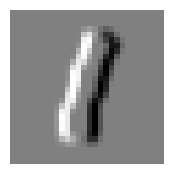

Cosine Similarity: 0.8810676336288452 MAE: 0.879
Cosine Similarity: 0.9075655937194824 MAE: 0.74
Cosine Similarity: 0.8740578889846802 MAE: 0.854
Cosine Similarity: 0.8781372308731079 MAE: 0.876
Cosine Similarity: 0.8774558305740356 MAE: 0.825
Cosine Similarity: 0.9369329810142517 MAE: 0.57
Cosine Similarity: 0.9131386280059814 MAE: 0.65
Cosine Similarity: 0.942297101020813 MAE: 0.571
Cosine Similarity: 0.9056246280670166 MAE: 0.761
Cosine Similarity: 0.9457781910896301 MAE: 0.562
Cosine Similarity: 0.893358588218689 MAE: 0.812
Cosine Similarity: 0.8957635760307312 MAE: 0.741
Cosine Similarity: 0.834204912185669 MAE: 0.923
Cosine Similarity: 0.8827775120735168 MAE: 0.822
Cosine Similarity: 0.8887167572975159 MAE: 0.791
Cosine Similarity: 0.8977210521697998 MAE: 0.732
Cosine Similarity: 0.885888397693634 MAE: 0.765
Cosine Similarity: 0.9190977215766907 MAE: 0.665
Cosine Similarity: 0.9325854182243347 MAE: 0.607
Cosine Similarity: 0.9116863012313843 MAE: 0.69
Cosine Similarity: 0.9175941

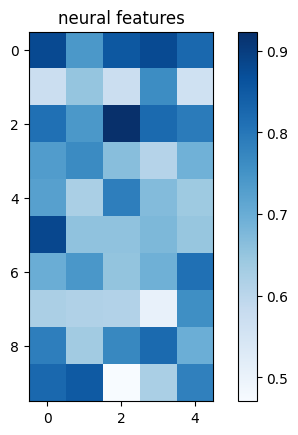

Predicted: 0


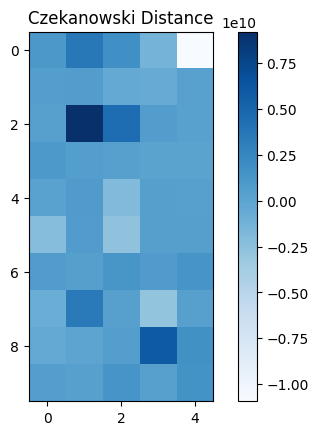

Predicted: 4


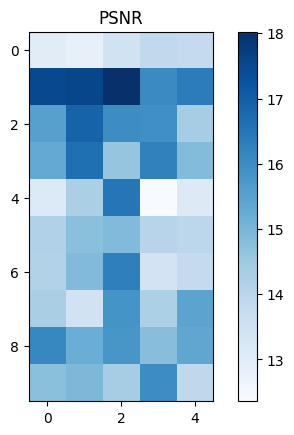

Predicted: 1


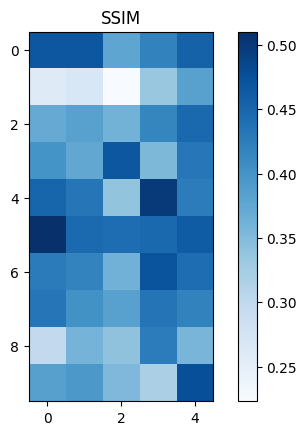

Predicted: 1


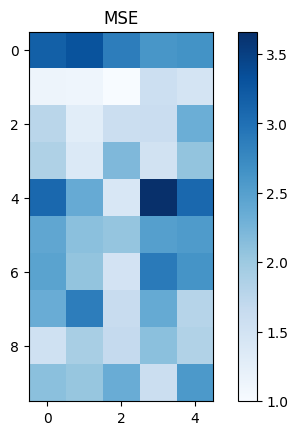

Predicted: 1


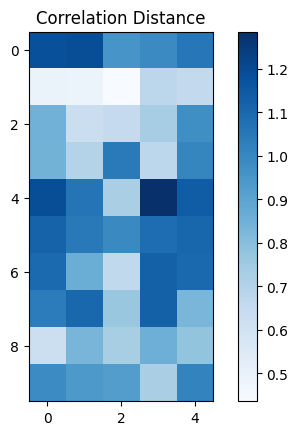

Predicted: 8


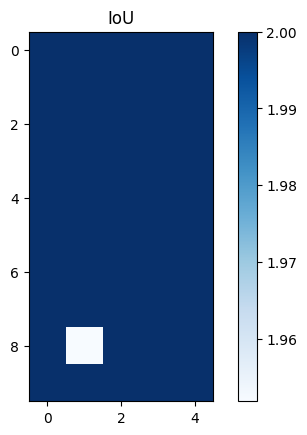

Predicted: 1


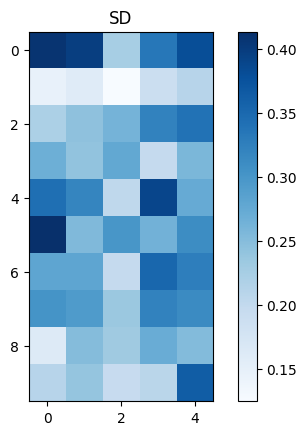

Predicted: 1


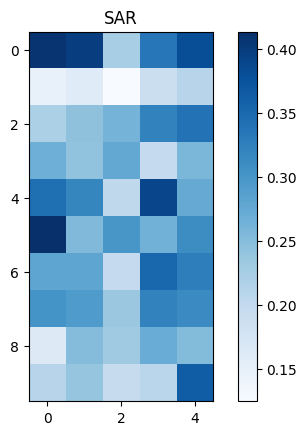

Predicted: 1


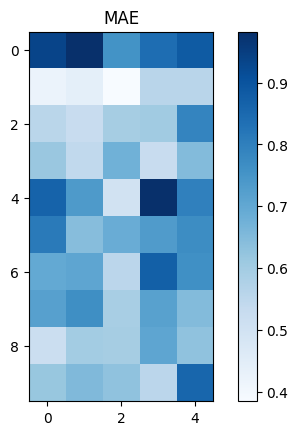

Predicted: 1


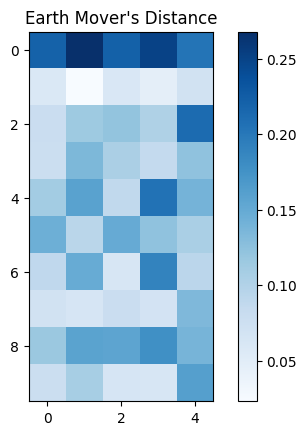

Predicted: 1


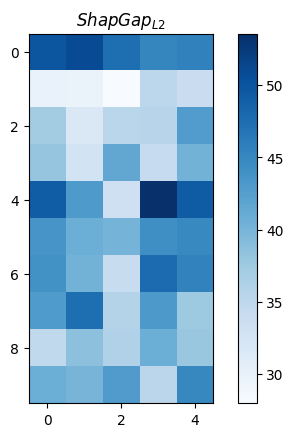

Predicted: 1


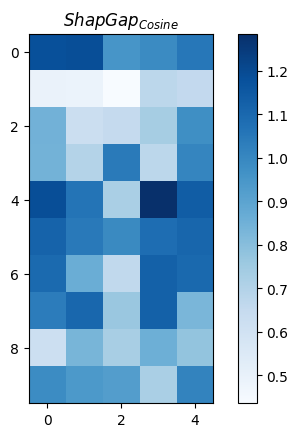

<Figure size 640x480 with 0 Axes>

In [69]:
plt.figure(figsize=(2,2))
random_image = X_train[np.random.randint(0, len(X_train))]
plt.imshow(random_image, cmap='gray')
plt.axis('off')
plt.show()
# test the metrics with a random image
def test_on_proto(im,metr):
    distances = np.zeros(shape=(10, k))
    for j,p in enumerate(prototypical_samples):
        for i,p_ in enumerate(p):
            #print(f"{metr.__name__}: {metr(im, p_)}")
            distances[j][i] = metr(im, p_)
            
    closest = np.argmin(distances.min(axis=1
                                      ), axis=0)
    
    print(f"Predicted: {closest}")
    # plot the image
    
    plt.imshow(distances, cmap="Blues")
    plt.colorbar()
    plt.title(f"{metr.__name__}")
    plt.show()
    plt.clf()
    
for metric in saliency_metrics:
    test_on_proto(random_image, metric)


In [16]:
class KNNImages:
    def __init__(self,metric_function, prototypical_samples,
                 clip=False, 
                 normalize=False,
                 sobel=False):
        """
        Initialize the Prototypical Network with a metric function and prototypical samples.
        """
        self.distances = np.array([])
        if clip:
            for j,pe_ in enumerate(prototypical_samples):
                for i,pe in enumerate(pe_):
                    prototypical_samples[j][i] = clip_mask(pe)
        if normalize:
            for j,pe_ in enumerate(prototypical_samples):
                for i,pe in enumerate(pe_):
                    prototypical_samples[j][i] = normalize_mask(pe)
        if sobel:
            for j,pe_ in enumerate(prototypical_samples):
                for i,pe in enumerate(pe_):
                    prototypical_samples[j][i] = sobel(pe)
        def get_prediction(image):
            """
            Compare two images and return a distance metric.
            """
            if clip:
                image = clip_mask(image)
            if normalize:
                image = normalize_mask(image)
            if sobel:
                image = sobel(image)
            distances = np.inf*np.ones(shape=(prototypical_samples.shape[0],
                                        prototypical_samples.shape[1]))
            classes = np.arange(prototypical_samples.shape[0]).repeat(prototypical_samples.shape[1])
            for i in range(prototypical_samples.shape[0]):
                for j in range(prototypical_samples.shape[1]):
                    distances[i][j] = metric_function(prototypical_samples[i][j], image)
            r=distances.min(axis=1)
            # print(distances.shape)
            # print(r)
            # print(r.shape)
            # print(r.argmin(axis=0))
            # print(r.argmin(axis=0).shape)
            return r.argmin(axis=0).astype(int)
            
            
        self.metric_function = metric_function
        self.get_prediction = get_prediction
        self.prototypical_samples = prototypical_samples
    def predict(self, query_samples):
        predictions = np.zeros(shape=(len(query_samples),), dtype=int)
        for i, query_sample in enumerate(query_samples):
            predictions[i] = self.get_prediction(query_sample)
        return predictions
    
dict_dataframe = pd.DataFrame({
    "saliency_metric": pd.Series(dtype='object'),
    "f1_score": pd.Series(dtype='float64'),
    "elapsed_time": pd.Series(dtype='float64'),
    "clip": pd.Series(dtype='bool'),
    "normalize": pd.Series(dtype='bool'),
    "sobel": pd.Series(dtype='bool')
})

# Compute the predicted class
for saliency_metric in saliency_metrics:
    print(f"Saliency Metric: {saliency_metric.__name__}")
    for sobel in [True,False]:
        for clip in [True,False]:
            for normalize in [True,False]:
                start = time.time()
                clf = KNNImages(saliency_metric, prototypical_samples.copy(),
                                clip=clip, normalize=normalize)
                
                predicted_class = clf.predict(X_test[:])
                # print exacltly 2 digits of the f1 score
                elapsed = time.time() - start
                print(f"Clip: {clip}\tNorm: {normalize}\tSobel:{sobel}\tF1 Score: {f1_score(y_test[:], predicted_class, average='weighted'):.2f} \tElapsed Time: {elapsed:.2f} seconds")
                # store the results in a dictionary
                # Create a new row with explicit dtypes
                new_row = pd.DataFrame({
                    "saliency_metric": [saliency_metric.__name__],
                    "f1_score": [f1_score(y_test[:], predicted_class, average='weighted')],
                    "elapsed_time": [elapsed],
                    "clip": [clip],
                    "normalize": [normalize],
                    "sobel": [sobel]
                })
                
                # Concatenate with proper dtypes
                dict_dataframe = pd.concat([dict_dataframe, new_row], ignore_index=True)
                
                
    print()

Saliency Metric: Czekanowski Distance
Clip: True	Norm: True	Sobel:True	F1 Score: 0.08 	Elapsed Time: 57.02 seconds
Clip: True	Norm: False	Sobel:True	F1 Score: 0.08 	Elapsed Time: 54.16 seconds
Clip: False	Norm: True	Sobel:True	F1 Score: 0.08 	Elapsed Time: 56.28 seconds
Clip: False	Norm: False	Sobel:True	F1 Score: 0.09 	Elapsed Time: 55.13 seconds
Clip: True	Norm: True	Sobel:False	F1 Score: 0.08 	Elapsed Time: 58.59 seconds
Clip: True	Norm: False	Sobel:False	F1 Score: 0.08 	Elapsed Time: 57.69 seconds
Clip: False	Norm: True	Sobel:False	F1 Score: 0.08 	Elapsed Time: 55.43 seconds
Clip: False	Norm: False	Sobel:False	F1 Score: 0.09 	Elapsed Time: 53.83 seconds

Saliency Metric: PSNR


KeyboardInterrupt: 

In [ ]:
dict_dataframe.to_json()

'{"saliency_metric":{"0":"Czekanowski Distance","1":"Czekanowski Distance","2":"Czekanowski Distance","3":"Czekanowski Distance","4":"Czekanowski Distance","5":"Czekanowski Distance","6":"Czekanowski Distance","7":"Czekanowski Distance","8":"PSNR","9":"PSNR","10":"PSNR","11":"PSNR","12":"PSNR","13":"PSNR","14":"PSNR","15":"PSNR","16":"SSIM","17":"SSIM","18":"SSIM","19":"SSIM","20":"SSIM","21":"SSIM","22":"SSIM","23":"SSIM","24":"MSE","25":"MSE","26":"MSE","27":"MSE","28":"MSE","29":"MSE","30":"MSE","31":"MSE","32":"Correlation Distance","33":"Correlation Distance","34":"Correlation Distance","35":"Correlation Distance","36":"Correlation Distance","37":"Correlation Distance","38":"Correlation Distance","39":"Correlation Distance","40":"IoU","41":"IoU","42":"IoU","43":"IoU","44":"IoU","45":"IoU","46":"IoU","47":"IoU","48":"SD","49":"SD","50":"SD","51":"SD","52":"SD","53":"SD","54":"SD","55":"SD","56":"SAR","57":"SAR","58":"SAR","59":"SAR","60":"SAR","61":"SAR","62":"SAR","63":"SAR","64":

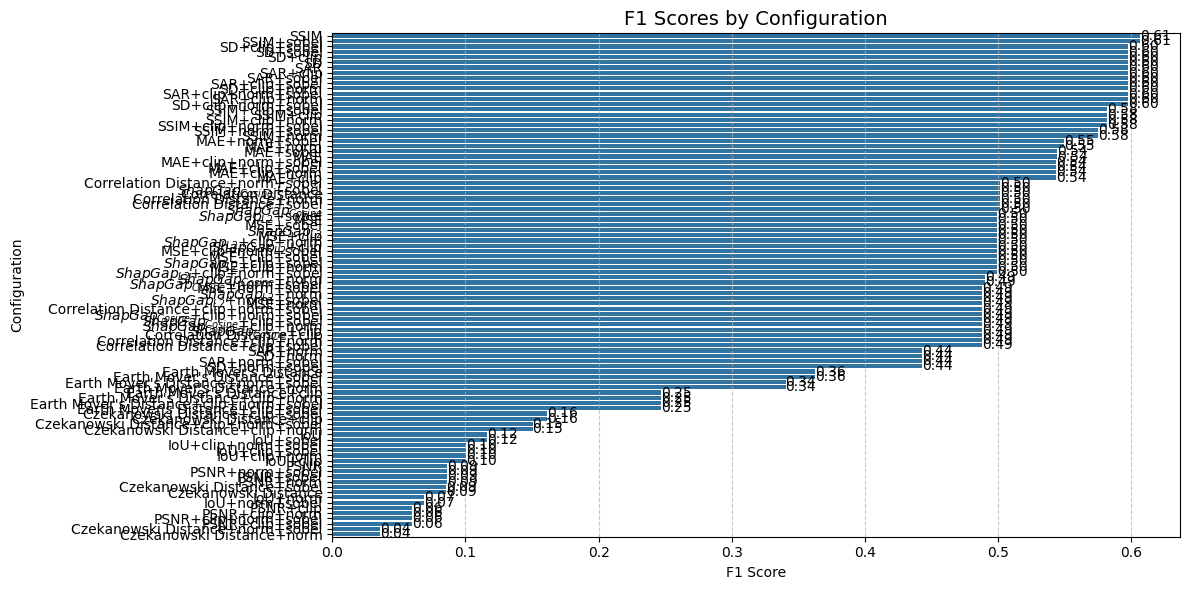

In [ ]:
import json 
results_str = dict_dataframe.to_json()
results = json.loads(results_str)
df = pd.DataFrame(results)

# Clean up metric names and create configuration labels
df['metric_name'] = df['saliency_metric'].apply(lambda x: x.replace('_distance', ''))
df['config_label'] = df.apply(
    lambda row: f"{row['metric_name']}" + 
                ("+clip" if row['clip'] else "") + 
                ("+norm" if row['normalize'] else "") +
                ("+sobel" if row['sobel'] else ""),
    axis=1
)

# 1. Bar plot with all combinations
plt.figure(figsize=(12, 6))
df_sorted = df.sort_values('f1_score', ascending=False)

ax1 = sns.barplot(y='config_label', x='f1_score', data=df_sorted)
ax1.set_title('F1 Scores by Configuration', fontsize=14)
ax1.set_ylabel('Configuration')
ax1.set_xlabel('F1 Score')
ax1.tick_params(axis='y', rotation=0)
ax1.grid(axis='x', linestyle='--', alpha=0.7)

# Add values ot the right of bars
for i, p in enumerate(ax1.patches):
    ax1.annotate(f'{df_sorted["f1_score"].iloc[i]:.2f}', 
                 (p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.savefig('f1_scores_by_config.pdf', dpi=300)
plt.show()


<Figure size 600x600 with 0 Axes>

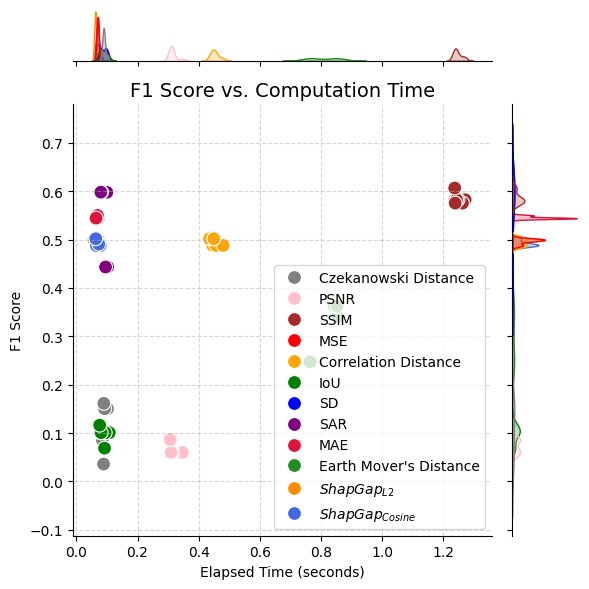

In [ ]:
# 2. Scatter plot: F1 vs time
plt.figure(figsize=(6, 6))

# Define color mapping for metrics
color_map = {'euclidean': 'royalblue', 
             'cosine': 'darkorange',
             'emd': 'forestgreen',
             'mean_absolute_error': 'crimson'}
color_map  ={"$ShapGap_{Cosine}$": 'royalblue', 
             "$ShapGap_{L2}$": 'darkorange',
             "Earth Mover's Distance": 'forestgreen',
             "MAE": 'crimson',
                "SAR": 'purple',
                "SD": 'blue',
                "IoU": 'green',
                "Correlation Distance": 'orange',
                "MSE": 'red',
                "SSIM": 'brown',
                "PSNR": 'pink',
                "Czekanowski Distance": 'gray'}

df['color'] = df['metric_name'].map(color_map)

# joint plot from sns using as hue the metric 
sns.jointplot(data=df, x='elapsed_time', y='f1_score', hue='metric_name', palette=color_map, s=100)
# Add a legend for the metrics
handles = [mpatches.Patch(color=color_map[name], label=name) for name in color_map.keys()]
plt.legend(handles=handles, title='Saliency Metric', loc='upper right')
# Set the title and labels


plt.title('F1 Score vs. Computation Time', fontsize=14)
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('F1 Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.savefig('f1_vs_time.pdf', dpi=300)
plt.show()


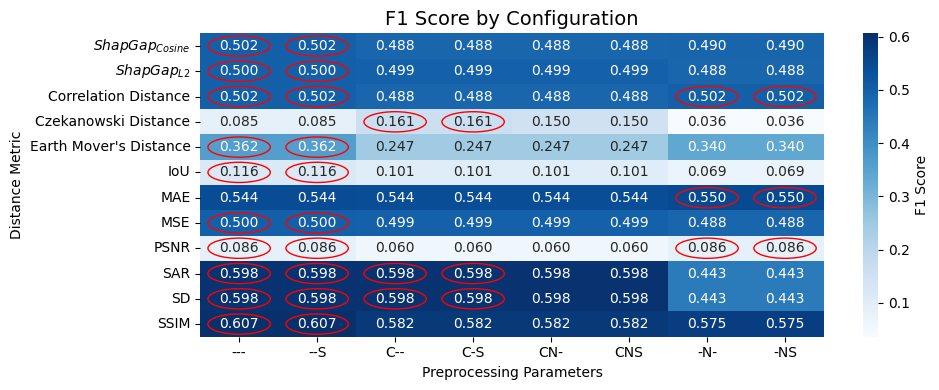

In [ ]:

# 3. Heatmap
plt.figure(figsize=(10, 4))

# Create pivot table for heatmap with simplified configuration labels
# Create a more detailed configuration code for the heatmap
df['config_col'] = df.apply(
    lambda row: ("C" if row['clip'] else "-") + 
                ("N" if row['normalize'] else "-") +
                ("S" if row['sobel'] else "-"),
    axis=1
)

# Add description for the configuration codes
config_desc = {
    "CNS": "clip+norm+sobel",
    "CN-": "clip+norm",
    "C-S": "clip+sobel",
    "C--": "clip only",
    "-NS": "norm+sobel",
    "-N-": "norm only",
    "--S": "sobel only",
    "---": "none"
}

heatmap_pivot = pd.pivot_table(
    df, 
    values='f1_score',
    index=['metric_name'],
    columns=['config_col'],
    aggfunc=np.mean
)

# Sort columns by performance
heatmap_pivot = heatmap_pivot.loc[:, heatmap_pivot.mean().sort_values(ascending=False).index]


# Create heatmap
ax = sns.heatmap(
    heatmap_pivot, 
    annot=True, 
    fmt='.3f', 
    cmap='Blues',#'YlGnBu', 
    cbar_kws={'label': 'F1 Score'},
    
)

# Add circles for each metric
best_configs = {}
for metric in heatmap_pivot.index:
    best_col = heatmap_pivot.loc[metric].idxmax()
    best_val = heatmap_pivot.loc[metric, best_col]

    best_configs[metric] = (best_col, best_val)
    # now iterate again over the columns to circle all the best values
    for col in heatmap_pivot.columns:
        val = heatmap_pivot.loc[metric, col]
        if val==best_val:
            # Add circle around to best configuration
            y_pos = list(heatmap_pivot.index).index(metric) + 0.5
            x_pos = list(heatmap_pivot.columns).index(col) + 0.5
            circle = plt.Circle((x_pos, y_pos), 0.4, color='red', fill=False, lw=1)
            ax.add_patch(circle)

ax.set_title('F1 Score by Configuration', fontsize=14)
ax.set_ylabel('Distance Metric')
ax.set_xlabel('Preprocessing Parameters')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('heatmap.pdf', dpi=300)
plt.show()


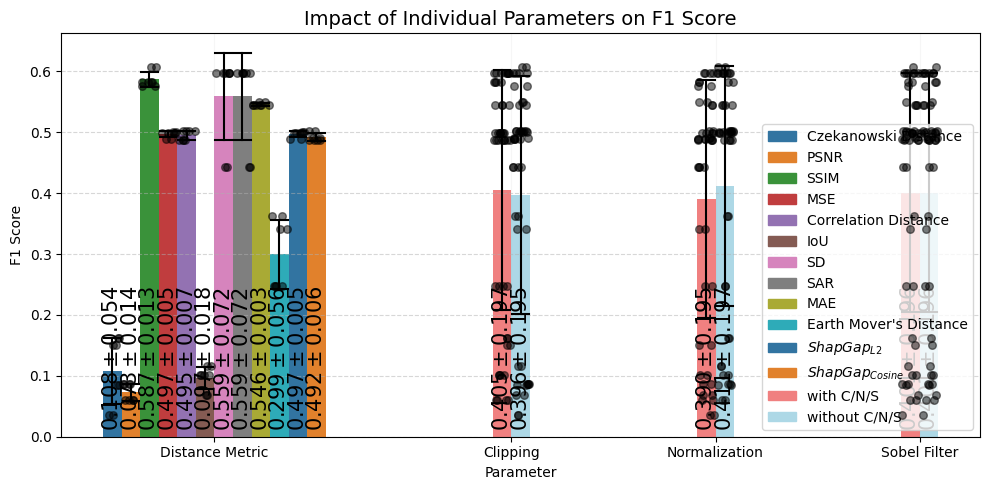

In [ ]:
# 4. Individual parameters impact
def plot_parameter_impact_with_std(df, metric_column='saliency_metric', score_column='f1_score'):
    """
    Create a parameter impact plot with standard deviation lines and scatter points.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing the results
    metric_column : str
        Column name containing the metric names
    score_column : str
        Column name containing the scores to analyze
    """
    # Clean up metric names if they contain '_distance' suffix
    df['metric_name'] = df[metric_column].apply(lambda x: x.replace('_distance', '') 
                                                if isinstance(x, str) and '_distance' in x 
                                                else x)
    
    # Get all unique values for the parameters
    unique_metrics = df['metric_name'].unique()
    
    # Initialize parameters dictionary
    parameter_stats = {
        'metric': {},
        'clip': {
            'with clip': {
                'mean': df[df['clip'] == True][score_column].mean(),
                'std': df[df['clip'] == True][score_column].std(),
                'values': df[df['clip'] == True][score_column].values
            },
            'without clip': {
                'mean': df[df['clip'] == False][score_column].mean(),
                'std': df[df['clip'] == False][score_column].std(),
                'values': df[df['clip'] == False][score_column].values
            }
        },
        'normalize': {
            'with norm': {
                'mean': df[df['normalize'] == True][score_column].mean(),
                'std': df[df['normalize'] == True][score_column].std(),
                'values': df[df['normalize'] == True][score_column].values
            },
            'without norm': {
                'mean': df[df['normalize'] == False][score_column].mean(),
                'std': df[df['normalize'] == False][score_column].std(),
                'values': df[df['normalize'] == False][score_column].values
            }
        },
        'sobel': {
            'with sobel': {
                'mean': df[df['sobel'] == True][score_column].mean(),
                'std': df[df['sobel'] == True][score_column].std(),
                'values': df[df['sobel'] == True][score_column].values
            },
            'without sobel': {
                'mean': df[df['sobel'] == False][score_column].mean(),
                'std': df[df['sobel'] == False][score_column].std(),
                'values': df[df['sobel'] == False][score_column].values
            }
        }
    }
    
    # Populate the metrics dynamically
    for metric in unique_metrics:
        parameter_stats['metric'][metric] = {
            'mean': df[df['metric_name'] == metric][score_column].mean(),
            'std': df[df['metric_name'] == metric][score_column].std(),
            'values': df[df['metric_name'] == metric][score_column].values
        }
    
    # Build data for DataFrame
    impact_data = {
        'Parameter': [],
        'Value': [],
        'Score': [],
        'Std Dev': []
    }
    
    # Add metrics data
    for metric in unique_metrics:
        impact_data['Parameter'].append('Distance Metric')
        impact_data['Value'].append(metric)
        impact_data['Score'].append(parameter_stats['metric'][metric]['mean'])
        impact_data['Std Dev'].append(parameter_stats['metric'][metric]['std'])
    
    # Add clip data
    for clip_val in ['with clip', 'without clip']:
        impact_data['Parameter'].append('Clipping')
        impact_data['Value'].append(clip_val)
        impact_data['Score'].append(parameter_stats['clip'][clip_val]['mean'])
        impact_data['Std Dev'].append(parameter_stats['clip'][clip_val]['std'])
    
    # Add normalize data
    for norm_val in ['with norm', 'without norm']:
        impact_data['Parameter'].append('Normalization')
        impact_data['Value'].append(norm_val)
        impact_data['Score'].append(parameter_stats['normalize'][norm_val]['mean'])
        impact_data['Std Dev'].append(parameter_stats['normalize'][norm_val]['std'])
    
    # Add sobel data
    for sobel_val in ['with sobel', 'without sobel']:
        impact_data['Parameter'].append('Sobel Filter')
        impact_data['Value'].append(sobel_val)
        impact_data['Score'].append(parameter_stats['sobel'][sobel_val]['mean'])
        impact_data['Std Dev'].append(parameter_stats['sobel'][sobel_val]['std'])
    

    # Convert to DataFrame
    impact_df = pd.DataFrame(impact_data)
    
    plt.figure(figsize=(10, 5))
    
    # Plot bars without error bars (we'll add them manually)
    ax = sns.barplot(x='Parameter', y='Score', hue='Value', data=impact_df, errorbar=None,width=2,palette='tab10')
    
    # Create a direct mapping between patches and dataframe rows
    # This ensures we don't get out-of-bounds errors
    bars_data = []
    for i, p in enumerate(ax.patches):
        # We need to figure out which row in impact_df corresponds to this patch
        # The order of the patches can be different from the order in impact_df
        # so we need to be careful
        if i < len(impact_df):
            bars_data.append({
                'patch': p,
                'x': p.get_x() + p.get_width() / 2,
                'y': p.get_height(),
                'std': impact_df['Std Dev'].iloc[i],
                'parameter': impact_df['Parameter'].iloc[i],
                'value': impact_df['Value'].iloc[i],
                # the color is the same if we are in the group relative to the single metrics 
                # if we are doing the grouping by clip or normalize we place the color as white
                # when the value is False and and black when True
                # this is because we have the grouped metrics and what chages is the flag
                'color': (p.get_facecolor() if impact_df['Parameter'].iloc[i] == 'Distance Metric' else 
                          'lightcoral' if (impact_df['Value'].iloc[i] == 'with clip' or
                                           impact_df['Value'].iloc[i] == 'with norm' or
                                           impact_df['Value'].iloc[i] == 'with sobel'
                                           ) else 'lightblue')
            })
            p.set_facecolor(bars_data[-1]['color'])
        else:
            print("Warning: More patches than data rows. Some patches may not be used.")
    xticks_pos = []
    averaged_bar_position = 0
    c=0
    hp=0
    # Add error bars and value annotations using our mapped data
    for bar_data in bars_data:
        x = bar_data['x']
        y = bar_data['y']
        std = bar_data['std']
        color = bar_data['color']
        # Add error bars
        
        color = 'black'
        ax.plot([x, x], [y-std, y+std],           color=color)
        ax.plot([x-0.05, x+0.05], [y-std, y-std], color=color)
        ax.plot([x-0.05, x+0.05], [y+std, y+std], color=color)
        
        # Add value annotations vertically above the bar
        ax.annotate(f"${y:.3f} \pm {std:.3f}$", #±
                   xy=(x, 0.01),
                   ha='center', va='bottom', 
                   fontsize=15, rotation=90)
        averaged_bar_position += x
        c+=1
        if hp==1 and c==2:
            xticks_pos.append(averaged_bar_position/c)
            averaged_bar_position = 0
            c=0
        if c == len(unique_metrics) and hp==0:
            xticks_pos.append(averaged_bar_position/c)
            averaged_bar_position = 0
            c=0
            hp=1
        
    # Get mapping of parameter+value to bar position
    bar_positions = {}
    for bar_data in bars_data:
        param = bar_data['parameter']
        value = bar_data['value']
        if param not in bar_positions:
            bar_positions[param] = {}
        bar_positions[param][value] = bar_data['x']
    

    # Add scatter points
    for param, values_dict in bar_positions.items():
        for value, x_pos in values_dict.items():
            if param == 'Distance Metric':
                metric = value
                values = parameter_stats['metric'][metric]['values']
            elif param == 'Clipping':
                values = parameter_stats['clip'][value]['values']
            elif param == 'Normalization':
                values = parameter_stats['normalize'][value]['values']
            elif param == 'Sobel Filter':
                values = parameter_stats['sobel'][value]['values']
            else:
                continue
                
            # Add jitter to x-positions
            jittered_x = [x_pos + np.random.uniform(-0.05, 0.05) for _ in range(len(values))]
            ax.scatter(jittered_x, values, color='black', alpha=0.5, s=30, zorder=10)
            

    # PLACE THE NICE LEGEND
    # Remove the auto-generated legend
    ax.get_legend().remove()

    # Create custom legend handles
    legend_handles = []

    # Add handles for metric colors (keeping original colors)
    for metric in unique_metrics:
        # Find the color of the first patch with this metric
        for bar in bars_data:
            if bar['parameter'] == 'Distance Metric' and bar['value'] == metric:
                legend_handles.append(mpatches.Patch(color=bar['color'], label=metric))
                break

    # Add handles for clip and normalize with your custom colors
    legend_handles.append(mpatches.Patch(color='lightcoral', label='with C/N/S'))
    legend_handles.append(mpatches.Patch(color='lightblue', label='without C/N/S'))

    # Add the custom legend
    ax.legend(handles=legend_handles, loc='best')


    ax.set_title(f'Impact of Individual Parameters on {score_column.replace("_", " ").title()}', fontsize=14)
    ax.set_xlabel('Parameter')
    ax.set_ylabel(score_column.replace('_', ' ').title())
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.grid(axis='x', linestyle='-', alpha=0.1)
    # Get unique parameters and set the xticks at the center of each parameter group
    unique_params = impact_df['Parameter'].unique()
    
    # Set the xtick positions and labels
    ax.set_xticks(xticks_pos)
    ax.set_xticklabels(unique_params)
    
    plt.tight_layout()
    return plt

plt = plot_parameter_impact_with_std(df)

plt.savefig('parameter_impact_modular.pdf')
plt.show()

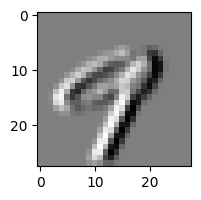

In [110]:
# plot the image
plt.figure(figsize=(2,2))
plt.imshow(image, cmap='gray')